In [1]:
import joblib
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder, RareLabelCategoricalEncoder, MeanCategoricalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from catboost.core import CatBoostRegressor

%matplotlib inline

In [2]:
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [3]:
data = pd.read_csv('house_prices_advanced_regression_techniques/train.csv')
train = data.copy(deep=True)
nanval_cols = ['Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'MiscFeature', 'FireplaceQu', 'PoolQC']
for i in nanval_cols:
    train[i].replace(np.NaN, 'No', regex=True, inplace=True)
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,No,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,No,No,No,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,No,No,No,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,No,No,No,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,No,No,No,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,No,No,No,0,12,2008,WD,Normal,250000


In [4]:
profile = ProfileReport(train, check_correlation=True)
profile

/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,81
Number of observations,1460
Total Missing (%),0.3%
Total size in memory,924.0 KiB
Average record size in memory,648.1 B
Numeric,38
Categorical,43
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [5]:
# sum all the areas into TotBuiltUpArea
train['TotBuiltUpArea'] = train.TotalBsmtSF.add(train['1stFlrSF']).add(train['2ndFlrSF']).add(train['GrLivArea']).add(train['GarageArea']).add(train.TotalBsmtSF)
train.drop(labels=['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'TotalBsmtSF'], axis=1, inplace=True)

In [6]:
# sum all the rooms into TotRoomsAbvGrd
train['TotRmsAbvGrd'] = train[['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']].sum(axis=1).add(train['TotRmsAbvGrd'])
train.drop(labels=['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis=1, inplace=True)

In [7]:
# Combining all porches SF into a single column and creating porches type indicator
porches = ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']

## summing all the porch SF into a single column
train['PorchSF'] = train.iloc[:,66:71].sum(axis=1)

## Creating porch class label
for i in range(len(porches)):
    train.loc[train[porches[i]] > 0, porches[i]] = i+1

train['PorchType'] = train[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

## Deleting redundant labels
train.drop(labels=porches, axis=1, inplace=True)

In [8]:
# remove columns
remove_cols = ['Id', 'Street', 'Utilities', 'Condition2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BedroomAbvGr','KitchenAbvGr', 'KitchenQual', 'PoolArea', 'PoolQC']
train.drop(labels=remove_cols, axis=1, inplace=True)

In [9]:
train['TransactionAge'] = dt.date.today().year - train['YrSold']
train['TransactionAge'] = 1/train['TransactionAge']

In [10]:
train['AgeAtSale'] = train['YrSold'].sub(train['YearBuilt'])

train['RemodAgeAtSale'] = train['YrSold'].sub(train['YearRemodAdd'])

# NaN values to have artibarily large numbers
train['GarageAgeAtSale'] = train['YrSold'].sub(train['GarageYrBlt'].fillna(0))

train.drop(labels=['MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

In [11]:
# missing value imputation
## Find out Missing Values.
missing_values = train.columns[train.isnull().any()].tolist()
print('Missing values: ', missing_values)

## First we'll fill in the sole missing value of 'Electricals' column with most frequent missing label.
train['Electrical'].fillna(value=train['Electrical'].mode()[0], inplace=True)

# Replacing 'MasVnrArea' with mean value, and 
train['MasVnrArea'].fillna(value=train.MasVnrArea.mean(), inplace=True)

train['MasVnrType'].fillna(value='missing', inplace=True)

missing_values = train.columns[train.isnull().any()].tolist()
print('Missing values: ', missing_values)

Missing values:  ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical']
Missing values:  ['LotFrontage']


In [12]:
# Load Preprocessed dataset with subset of variables from the dataset 
imputed_values = joblib.load('imputed_values.pkl')

# Replacing missing values of LotFrontage.
train.loc[train['LotFrontage'].isnull(),'LotFrontage'] = imputed_values

In [13]:
# Log transformation variables
log_cols = ['LotFrontage', 'LotArea']
for i in log_cols:
    train[i] = np.log(train[i])

In [14]:
if len(train.columns[train.isnull().any()].tolist())>0:
    print('Missing Values: ', train.columns[train.isnull().any()].tolist())
else:
    print('No NaN values found!')
print('='*15)

No NaN values found!


In [15]:
profile = ProfileReport(train, check_correlation=True, )
profile

/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,56
Number of observations,1460
Total Missing (%),0.0%
Total size in memory,638.9 KiB
Average record size in memory,448.1 B
Numeric,17
Categorical,38
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [16]:
X = train.drop(labels=['SalePrice'], axis=1)
y = train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

col_names = train.columns.tolist()
col_names.remove('SalePrice')

In [17]:
continuous = ['LotFrontage', 'LotArea', 'MasVnrArea', 'Fireplaces', 'GarageCars', 'MiscVal', 'TotBuiltUpArea', 'PorchSF', 'AgeAtSale']
nom_int = ['MSSubClass', 'PorchType', 'TransactionAge']
nom_obj = ['MSZoning', 'Alley', 'LandContour', 'LotShape','LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']
ord_int = ['OverallQual', 'OverallCond']
ord_obj = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']

In [18]:
pipe = Pipeline([
    ('rareLabels', RareLabelCategoricalEncoder(n_categories=5, variables=nom_obj)),
    ('ordinal_encode', OrdinalCategoricalEncoder(variables=ord_obj))
])
pipe.fit(X_train, y_train)

/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable LandContour is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be consi

Pipeline(steps=[('rareLabels',
                 RareLabelCategoricalEncoder(n_categories=5,
                                             variables=['MSZoning', 'Alley',
                                                        'LandContour',
                                                        'LotShape', 'LotConfig',
                                                        'LandSlope',
                                                        'Neighborhood',
                                                        'Condition1',
                                                        'BldgType',
                                                        'HouseStyle',
                                                        'RoofStyle', 'RoofMatl',
                                                        'Exterior1st',
                                                        'Exterior2nd',
                                                        'MasVnrType',
                                     

In [19]:
X_train = pipe.transform(X_train)
X_valid = pipe.transform(X_valid)

In [20]:
params = {'iterations':5000, 
          'learning_rate':0.001, 
          'depth':5,
          'loss_function':'RMSE', 
          'eval_metric':'RMSE', 
          'random_seed': 0, 
          'od_type':'Iter', 
          'metric_period':50, 
          'od_wait':20,
          'verbose': True, 
          'use_best_model': True, 
          'reg_lambda':0.1, 
          'cat_features':nom_obj}

model = CatBoostRegressor(**params)


model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 78414.1206934	test: 83054.3102018	best: 83054.3102018 (0)	total: 60.2ms	remaining: 5m
50:	learn: 75778.6840758	test: 80463.6220646	best: 80463.6220646 (50)	total: 514ms	remaining: 49.9s
100:	learn: 73288.1405511	test: 78019.7173423	best: 78019.7173423 (100)	total: 934ms	remaining: 45.3s
150:	learn: 70929.8668119	test: 75742.7664762	best: 75742.7664762 (150)	total: 1.43s	remaining: 45.9s
200:	learn: 68678.5526463	test: 73560.8995551	best: 73560.8995551 (200)	total: 1.85s	remaining: 44.2s
250:	learn: 66554.5657304	test: 71483.0990077	best: 71483.0990077 (250)	total: 2.34s	remaining: 44.3s
300:	learn: 64504.4123720	test: 69514.0036713	best: 69514.0036713 (300)	total: 2.84s	remaining: 44.3s
350:	learn: 62566.7868718	test: 67640.4835415	best: 67640.4835415 (350)	total: 3.31s	remaining: 43.8s
400:	learn: 60686.6540853	test: 65822.4732686	best: 65822.4732686 (400)	total: 3.76s	remaining: 43.1s
450:	learn: 58908.1300353	test: 64108.1398722	best: 64108.1398722 (450)	total: 4.18s	remai

4000:	learn: 21127.2804146	test: 32456.3420172	best: 32456.3420172 (4000)	total: 35.4s	remaining: 8.85s
4050:	learn: 21022.2884365	test: 32406.6650736	best: 32406.6650736 (4050)	total: 35.9s	remaining: 8.4s
4100:	learn: 20928.5980238	test: 32377.2286003	best: 32377.2286003 (4100)	total: 36.3s	remaining: 7.96s
4150:	learn: 20835.6350780	test: 32349.0068227	best: 32349.0068227 (4150)	total: 36.8s	remaining: 7.52s
4200:	learn: 20750.1574491	test: 32308.6445827	best: 32308.6445827 (4200)	total: 37.2s	remaining: 7.08s
4250:	learn: 20661.2014381	test: 32269.0715445	best: 32268.9282552 (4248)	total: 37.6s	remaining: 6.63s
4300:	learn: 20570.6793811	test: 32240.0317010	best: 32238.2542728 (4297)	total: 38.1s	remaining: 6.19s
4350:	learn: 20485.7474035	test: 32213.3561969	best: 32212.5020363 (4348)	total: 38.5s	remaining: 5.75s
4400:	learn: 20404.7339338	test: 32174.2295966	best: 32174.2295966 (4400)	total: 39s	remaining: 5.3s
4450:	learn: 20321.2756682	test: 32141.2876819	best: 32141.1151096 (

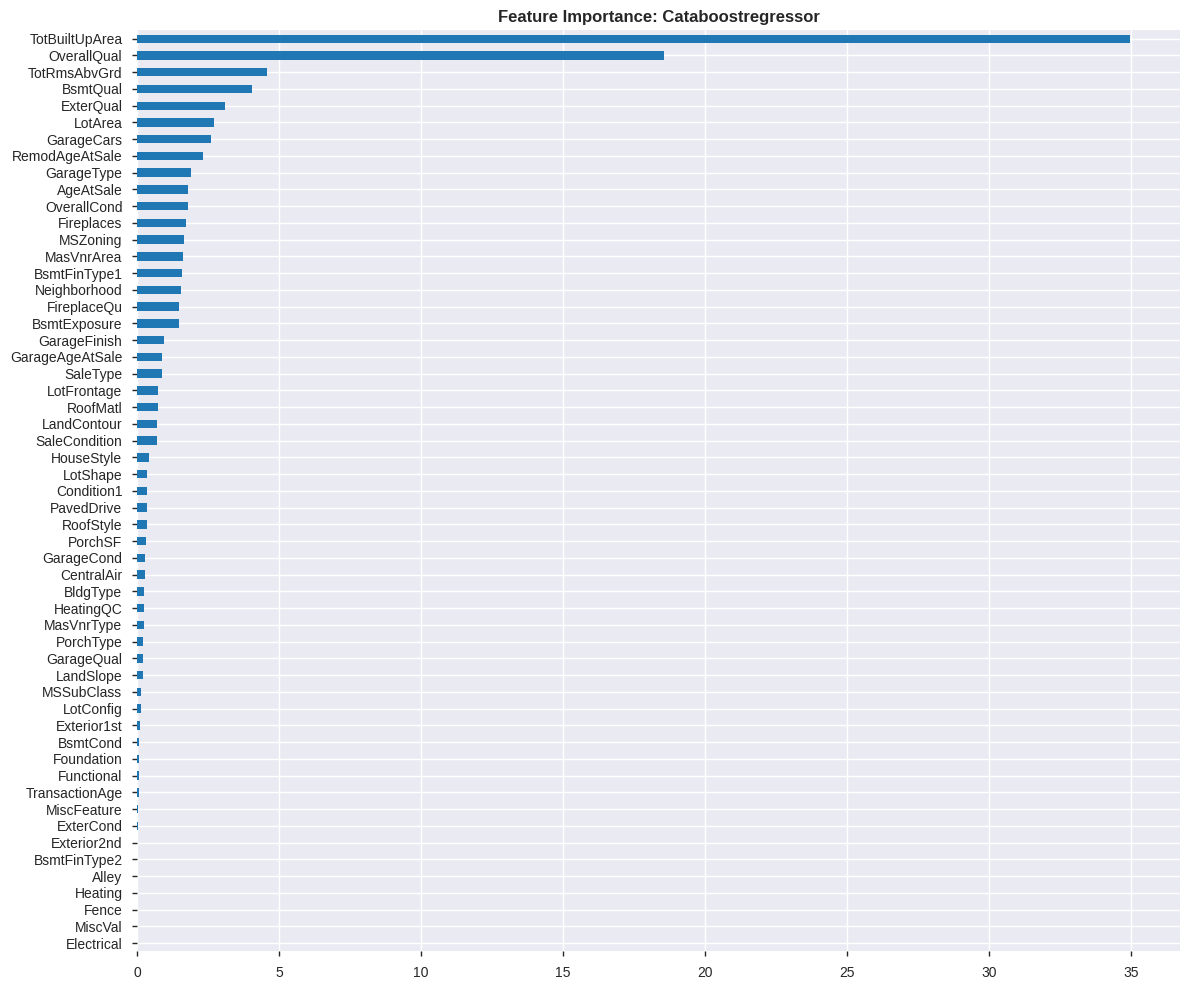

In [21]:
plt.figure(figsize=(12,10))
pd.Series(model.get_feature_importance(), index=col_names).sort_values().plot(kind='barh');
plt.title('Feature Importance: Cataboostregressor', fontweight='semibold')
plt.tight_layout()
plt.show()

#### Preventing Overfitting through Feature Selection

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
pipe = Pipeline([
    ('rareLabels', RareLabelCategoricalEncoder(n_categories=5, variables=nom_obj)),
    ('mean_encod', MeanCategoricalEncoder(variables=nom_obj)),
    ('ordinal_encode', OrdinalCategoricalEncoder(variables=ord_obj)),
    ('selector', RFE(estimator=GradientBoostingRegressor(random_state=0)))
])
pipe.fit(X_train, y_train)

/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be considered frequent".format(var))
/home/nm/miniconda3/envs/temp/lib/python3.7/site-packages/feature_engine/categorical_encoders.py:786: UserWarning: The number of unique categories for variable LandContour is less than that indicated in n_categories. Thus, all categories will be considered frequent
  "n_categories. Thus, all categories will be consi

Pipeline(steps=[('rareLabels',
                 RareLabelCategoricalEncoder(n_categories=5,
                                             variables=['MSZoning', 'Alley',
                                                        'LandContour',
                                                        'LotShape', 'LotConfig',
                                                        'LandSlope',
                                                        'Neighborhood',
                                                        'Condition1',
                                                        'BldgType',
                                                        'HouseStyle',
                                                        'RoofStyle', 'RoofMatl',
                                                        'Exterior1st',
                                                        'Exterior2nd',
                                                        'MasVnrType',
                                     

In [48]:
# Transforming the Datasets
col_names_new = np.array(col_names)[pipe.named_steps.selector.support_]
X_train_new = pd.DataFrame(data=pipe.named_steps.selector.transform(X_train), columns=col_names_new)
X_valid_new = pd.DataFrame(data=pipe.named_steps.selector.transform(X_valid), columns=col_names_new)

In [49]:
# Revising column names
cont_new = [i for i in continuous if i in col_names_new]
nom_int_new = [i for i in nom_int if i in col_names_new]
nom_obj_new = [i for i in nom_obj if i in col_names_new]
ord_int_new = [i for i in ord_int if i in col_names_new]
ord_obj_new = [i for i in ord_obj if i in col_names_new]

In [50]:
# Transforming Ordinal variables
ord_encode = OrdinalCategoricalEncoder(variables=ord_obj_new)
X_train_new = ord_encode.fit_transform(X_train_new, y_train)
X_valid_new = ord_encode.transform(X_valid_new)

In [56]:
params = {'iterations':5000, 
          'learning_rate':0.001, 
          'depth':5,
          'loss_function':'RMSE', 
          'eval_metric':'RMSE', 
          'random_seed': 0, 
          'od_type':'Iter', 
          'metric_period':50, 
          'od_wait':15,
          'verbose': False, 
          'l2_leaf_reg':0.1,
          'cat_features': nom_obj_new}

grid = {'learning_rate': [0.03, 0.01, 0.05],
        'depth': [3, 4, 5],
        'l2_leaf_reg': [0.1, 0.3, 0.5, 0.7, 0.9]}

model = CatBoostRegressor(**params)

grid_search_result = model.grid_search(grid, X=X_train_new, y=y_train, cv=5)

Stopped by overfitting detector  (15 iterations wait)

bestTest = 34175.81238
bestIteration = 132

0:	loss: 34175.8123791	best: 34175.8123791 (0)	total: 304ms	remaining: 13.4s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33367.50741
bestIteration = 359

1:	loss: 33367.5074109	best: 33367.5074109 (1)	total: 923ms	remaining: 19.8s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 33184.97151
bestIteration = 103

2:	loss: 33184.9715067	best: 33184.9715067 (2)	total: 1.11s	remaining: 15.5s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33332.47663
bestIteration = 119

3:	loss: 33332.4766269	best: 33184.9715067 (2)	total: 1.36s	remaining: 14s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33741.29031
bestIteration = 348

4:	loss: 33741.2903051	best: 33184.9715067 (2)	total: 1.96s	remaining: 15.7s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 34467.15801
bestIteration = 89

5:	loss: 34467.1580088	best: 33184.9715067 (2)	total: 2.12s	remaining: 13.8s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33548.31128
bestIteration = 119

6:	loss: 33548.3112752	best: 33184.9715067 (2)	total: 2.36s	remaining: 12.8s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33709.87211
bestIteration = 327

7:	loss: 33709.8721095	best: 33184.9715067 (2)	total: 2.92s	remaining: 13.5s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33503.56873
bestIteration = 136

8:	loss: 33503.5687303	best: 33184.9715067 (2)	total: 3.17s	remaining: 12.7s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33406.62649
bestIteration = 117

9:	loss: 33406.6264886	best: 33184.9715067 (2)	total: 3.39s	remaining: 11.9s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33589.30036
bestIteration = 401

10:	loss: 33589.3003560	best: 33184.9715067 (2)	total: 4.07s	remaining: 12.6s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 34262.94977
bestIteration = 80

11:	loss: 34262.9497674	best: 33184.9715067 (2)	total: 4.22s	remaining: 11.6s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33450.7809
bestIteration = 129

12:	loss: 33450.7808966	best: 33184.9715067 (2)	total: 4.48s	remaining: 11s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33716.26284
bestIteration = 381

13:	loss: 33716.2628363	best: 33184.9715067 (2)	total: 5.12s	remaining: 11.3s
Stopped by overfitting detector  (15 iterations wait)

bestTest = 34016.16871
bestIteration = 71

14:	loss: 34016.1687137	best: 33184.9715067 (2)	total: 5.26s	remaining: 10.5s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33798.96168
bestIteration = 126

15:	loss: 33798.9616831	best: 33184.9715067 (2)	total: 5.6s	remaining: 10.2s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33847.30903
bestIteration = 348

16:	loss: 33847.3090320	best: 33184.9715067 (2)	total: 6.42s	remaining: 10.6s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 34230.55835
bestIteration = 75

17:	loss: 34230.5583500	best: 33184.9715067 (2)	total: 6.62s	remaining: 9.93s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 31565.44866
bestIteration = 171

18:	loss: 31565.4486635	best: 31565.4486635 (18)	total: 7.07s	remaining: 9.67s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 34006.21044
bestIteration = 358

19:	loss: 34006.2104392	best: 31565.4486635 (18)	total: 7.91s	remaining: 9.89s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33685.61861
bestIteration = 125

20:	loss: 33685.6186124	best: 31565.4486635 (18)	total: 8.24s	remaining: 9.41s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33886.14992
bestIteration = 169

21:	loss: 33886.1499178	best: 31565.4486635 (18)	total: 8.68s	remaining: 9.07s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33933.57068
bestIteration = 325

22:	loss: 33933.5706849	best: 31565.4486635 (18)	total: 9.44s	remaining: 9.03s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 34163.56993
bestIteration = 79

23:	loss: 34163.5699342	best: 31565.4486635 (18)	total: 9.66s	remaining: 8.46s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33560.59596
bestIteration = 179

24:	loss: 33560.5959622	best: 31565.4486635 (18)	total: 10.1s	remaining: 8.09s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 32072.55399
bestIteration = 458

25:	loss: 32072.5539933	best: 31565.4486635 (18)	total: 11.2s	remaining: 8.16s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33835.19754
bestIteration = 74

26:	loss: 33835.1975356	best: 31565.4486635 (18)	total: 11.4s	remaining: 7.59s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33382.5514
bestIteration = 169

27:	loss: 33382.5514005	best: 31565.4486635 (18)	total: 11.8s	remaining: 7.18s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 31909.56827
bestIteration = 507

28:	loss: 31909.5682676	best: 31565.4486635 (18)	total: 13s	remaining: 7.16s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 34067.85174
bestIteration = 86

29:	loss: 34067.8517364	best: 31565.4486635 (18)	total: 13.2s	remaining: 6.62s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33164.34215
bestIteration = 184

30:	loss: 33164.3421545	best: 31565.4486635 (18)	total: 13.8s	remaining: 6.25s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 32652.17797
bestIteration = 514

31:	loss: 32652.1779679	best: 31565.4486635 (18)	total: 15.4s	remaining: 6.27s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 32393.32885
bestIteration = 138

32:	loss: 32393.3288473	best: 31565.4486635 (18)	total: 15.9s	remaining: 5.79s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 32792.54703
bestIteration = 192

33:	loss: 32792.5470316	best: 31565.4486635 (18)	total: 16.6s	remaining: 5.36s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33760.86854
bestIteration = 350

34:	loss: 33760.8685371	best: 31565.4486635 (18)	total: 17.7s	remaining: 5.04s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 34982.51297
bestIteration = 65

35:	loss: 34982.5129721	best: 31565.4486635 (18)	total: 17.9s	remaining: 4.48s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 34455.77072
bestIteration = 117

36:	loss: 34455.7707175	best: 31565.4486635 (18)	total: 18.3s	remaining: 3.96s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33936.74337
bestIteration = 355

37:	loss: 33936.7433674	best: 31565.4486635 (18)	total: 19.4s	remaining: 3.58s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 34211.5474
bestIteration = 71

38:	loss: 34211.5473987	best: 31565.4486635 (18)	total: 19.7s	remaining: 3.03s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 32986.01762
bestIteration = 161

39:	loss: 32986.0176233	best: 31565.4486635 (18)	total: 20.3s	remaining: 2.54s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 32824.35103
bestIteration = 492

40:	loss: 32824.3510333	best: 31565.4486635 (18)	total: 21.8s	remaining: 2.13s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 32249.00534
bestIteration = 178

41:	loss: 32249.0053441	best: 31565.4486635 (18)	total: 22.4s	remaining: 1.6s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 33008.61444
bestIteration = 173

42:	loss: 33008.6144390	best: 31565.4486635 (18)	total: 23s	remaining: 1.07s


Stopped by overfitting detector  (15 iterations wait)

bestTest = 32981.46062
bestIteration = 455

43:	loss: 32981.4606179	best: 31565.4486635 (18)	total: 24.4s	remaining: 555ms


Stopped by overfitting detector  (15 iterations wait)

bestTest = 34498.26514
bestIteration = 65

44:	loss: 34498.2651367	best: 31565.4486635 (18)	total: 24.7s	remaining: 0us
Estimating final quality...


Stopped by overfitting detector  (15 iterations wait)


In [61]:
print('Validation RMSE: %.3f' % np.min(grid_search_result['cv_results']['test-RMSE-mean']))

Validation RMSE: 25559.902


In [62]:
y_pred = model.predict(X_valid_new)

print('Holdout set RMSE: %.3f' % mean_squared_error(y_valid, y_pred)**0.5)

Holdout set RMSE: 29213.229


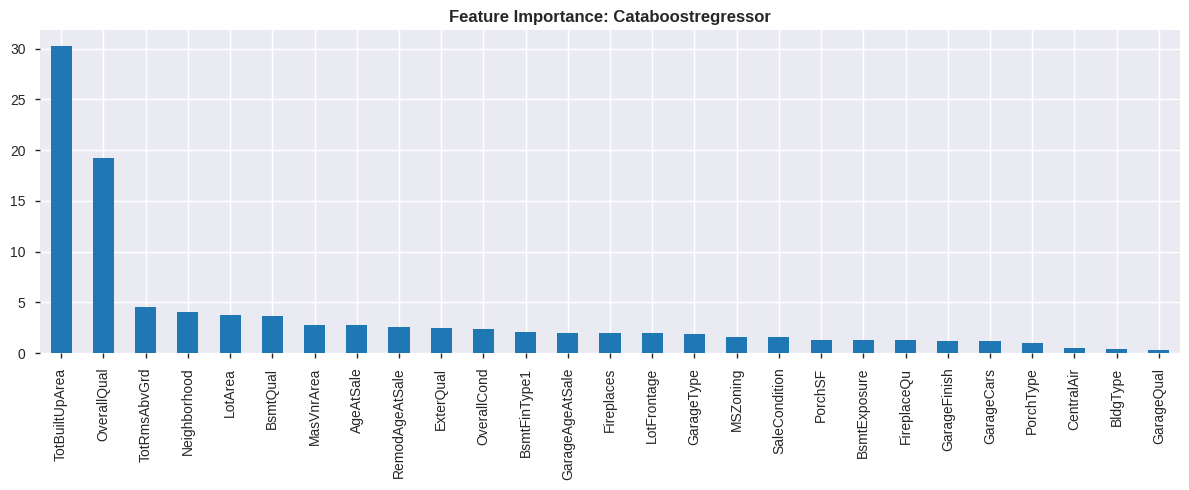

In [67]:
plt.figure(figsize=(12,5))
pd.Series(model.get_feature_importance(), index=col_names_new).sort_values(ascending=False).plot(kind='bar');
plt.title('Feature Importance: Cataboostregressor', fontweight='semibold')
plt.tight_layout()
plt.show()